# Segmentation

In this notebook, we test the part segmentation based on nearest centroid classification.

In [12]:
import torch
import os
from hydra import compose, initialize
from src.dataset.pascalparts import PascalParts
from src.models.featurizer.utils import get_featurizer_name, get_featurizer
from src.models.classifier.utils import train_classifier
from src.models.classifier.utils import forward_classifier
from src.models.featurizer_refine import load_checkpoint
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import matplotlib.pyplot as plt
%matplotlib inline
from src.evaluation import STOREBASEPATH
torch.cuda.set_device(0)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Configuration File Loading

The configuration file `configs/demo_segmenation_nearest_centroid`should specify the dataset and featurizer. In order to test multiple configurations, you can change the file accordingly.

In [13]:
with initialize(config_path="./configs", job_name="test_app"):
    args = compose(config_name="demo_segmenation_nearest_centroid")

### Dataset Loading

First, we will load the datasat specified in the configutation file containing part segmentation annotation.

In [14]:
if args.dataset.name == 'pascalparts':
    dataset_train = PascalParts(args.dataset, split="train")
    dataset = PascalParts(args.dataset, split="test")

else:
    raise ValueError(f"Dataset {args.dataset.name} does not provide part annotations")

### Category Selection

The category can be changed according to the dataset at hand.

In [15]:
print(dataset.all_cats)
# We choose the first category
cat = "cat"
dataset.init_kps_cat(cat)
dataset_train.init_kps_cat(cat)
print(f"Category: {cat}")

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'table', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
Category: cat


### Featurizer Initialization
Load the featurizer specified in the configuation file.

In [16]:
preprocessed = False # True if we want to use preprocessed features, which are already stored to disk
if preprocessed:
    featurizer_name = get_featurizer_name(args.featurizer)
    dataset.featurizer_name = featurizer_name
    dataset_train.featurizer_name = featurizer_name
else:
    print(f"Memory allocated before loading: {torch.cuda.memory_allocated()//1024**2} MB")
    if args.featurizer.model == 'dift_sd':
        args.featurizer.all_cats = dataset.all_cats
    featurizer = get_featurizer(args.featurizer)
    dataset.featurizer = featurizer
    dataset.featurizer_kwargs = args.featurizer
    dataset.featurizer_name = featurizer.name
    dataset_train.featurizer = featurizer
    dataset_train.featurizer_kwargs = args.featurizer
    dataset_train.featurizer_name = featurizer.name
    print(f"Memory allocated after loading: {torch.cuda.memory_allocated()//1024**2} MB")
print(f"Featurizer: {dataset.featurizer_name}")

Memory allocated before loading: 355 MB


Using cache found in /dev/shm/hreg/cache/torch/hub/facebookresearch_dinov2_main


Memory allocated after loading: 358 MB
Featurizer: geco


### Feature Refiner Initialization
In case of loading some basline architecture, we have to process the feature output of the foundation model to obtain the final features.

In [17]:
if 'feat_refine' in args:
    model_refine = load_checkpoint(args.feat_refine)
else:
    model_refine = None

## Train Part Segmentation
Train the segmentation model. We use a nearest centroid classifier, assigning one centroid per part.

In [18]:

print(f'Segmentation Model: {args.sup_classifier.model}')
model_seg = train_classifier(args.sup_classifier, dataset_train, model_refine=model_refine)

Segmentation Model: nearest_centroid_fg


## Visualize Part Segmentation

In [19]:
def get_store_path(dataset, model_seg, model_refine=None):
    """
    Get the path to store the figures
    :param dataset: dataset object
    :param model_seg: segmentation model
    :param model_refine: refinement model
    :return: path to store the figures
    """
    path = STOREBASEPATH+'/05_experiments/'
    if model_refine is not None:
        store_path = path+model_seg.name+'/'+dataset.name+'/'+cat+'/'+model_refine.id+'/'
    else:
        store_path = path+model_seg.name+'/'+dataset.name+'/'+cat+'/'+dataset.featurizer_name+'/'
    if not os.path.exists(store_path):
        os.makedirs(store_path)
    return store_path

def store_figures(fig, ax, store_path):
    """
    Store the figures in the given path
    :param fig: figure object
    :param ax: axis object
    :param store_path: path to store the figures
    """
    for i, a in enumerate(ax.flatten()):
        # save the axis as a separate image
        extent = a.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        title = a.get_title().replace(' ', '_')
        fig.savefig(f'{store_path}{title}.png', bbox_inches=extent)

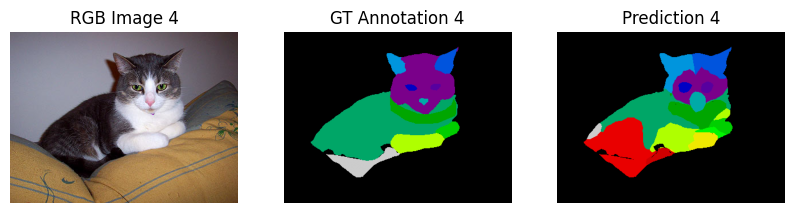

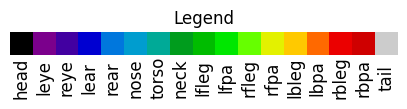

In [23]:
idx = 4
store = True

data = dataset[idx]
num_parts = len(dataset.KP_NAMES)

#  1. Get the image
img = dataset.get_img(idx)

#  2. Generate Part Segmentation from the dataset
prt_anno = data['parts_mask'][None]
# get part labels from 0 to num_parts
y_anno = prt_anno.argmax(1, keepdim=True)+1 # we want to start from 1, 0 is the background
# set the background to 0
y_anno[prt_anno.sum(1, keepdim=True)< 1e-20] = 0


# 3. Generate Part Segmentation from Features
prt = forward_classifier(dataset, idx, model_seg, model_refine=model_refine)
# get part labels from 0 to num_parts
y = prt.argmax(1, keepdim=True)+1
# set the background to 0
y[prt_anno.sum(1, keepdim=True).repeat(1,1,1,1)<1e-20] = 0


# Plot the image and the segmentation
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# 1. Plot the image
ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title(f"RGB Image {idx}")

# 2. Plot the part segmentation annotation from the dataset
y_anno = y_anno/num_parts
ax[1].imshow(y_anno[0].permute(1,2,0).cpu().numpy(), vmin=0, vmax=1, cmap='nipy_spectral')
ax[1].axis('off')
ax[1].set_title(f"GT Annotation {idx}")

# 3. Plot the segmentation from the model
y = y/num_parts
ax[2].imshow(y[0].permute(1,2,0).detach().cpu().numpy(), vmin=0, vmax=1, cmap='nipy_spectral')
ax[2].axis('off')
ax[2].set_title(f"Prediction {idx}")

# Store the figure
if store:
    store_path = get_store_path(dataset, model_seg, model_refine=model_refine)
    store_figures(fig, ax, store_path)

# Get a legend with colors for each part
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
prts = torch.linspace(0,1,steps=num_parts)
ax.imshow(prts.repeat(1,1,1).permute(1,2,0).cpu().numpy(), cmap='nipy_spectral')
# Add the names of the parts to the legend
for i, kp in enumerate(dataset.KP_NAMES):
    ax.text((i+0.5)/num_parts, -1, kp, color='black', fontsize=12, ha='center', va='center', transform=ax.transAxes, rotation=90)
ax.set_title(f"Legend")
ax.axis('off')
plt.draw()